In [1]:
%load_ext autoreload
%autoreload 2
import site, sys, os, time
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [226]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from jax import random
from src.utils import create_2d_mask

### GMM

In [209]:
def gen_gauss_x(amp, centre, x, sig):
    return amp * jnp.exp(-(x-centre)**2/(2*sig**2))

gen_gauss_x_vmap = jax.vmap(gen_gauss_x, in_axes=(0, 0, None,None))

def pts2img(amp, pts, x_grid, sig):
    p_x = gen_gauss_x_vmap(amp, pts[:,0], x_grid, sig)
    p_y = gen_gauss_x_vmap(jnp.ones(amp.shape), pts[:,1], x_grid, sig) 
    return jnp.matmul(p_x.transpose(), p_y).transpose() 

#pts2img_vmap = jax.vmap(pts2img_one, in_axes=0)


def rotate_and_project(amp, theta, pts, x_grid, sig):
    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    pts = (R @ pts.transpose()).transpose()
    img = pts2img(amp, pts, x_grid, sig)
    proj = jnp.sum(img, axis=0)
    
    return proj, img, pts

In [323]:
def get_fwd_model(pts, x_grid, sig):
    
    @jax.jit
    def fwd_model(amp, theta):
        proj, _, _ = rotate_and_project(amp, theta, pts, x_grid, sig)
        return proj
    
    fwd_model_vmap = jax.jit(jax.vmap(fwd_model, in_axes = (None, 0)))
    
    return fwd_model, fwd_model_vmap

def get_loss_function(fwd_model_vmap, thetas, data):
    
    @jax.jit
    def loss_func(amp): 
        err = fwd_model_vmap(amp, thetas) - data
        return 1/2 * jnp.sum(err**2) / jnp.prod(jnp.array(err.shape))
    
    grad_loss_func = jax.jit(jax.grad(loss_func))
    
    return loss_func, grad_loss_func

In [264]:
nx = 32
x_grid = jnp.fft.fftshift(jnp.fft.fftfreq(nx))
sigma = 0.05
amp = 10 + jnp.array(np.random.randn(nx*nx))


In [265]:
X, Y = jnp.meshgrid(x_grid, x_grid)
pts = jnp.array([X.ravel(), Y.ravel()]).transpose()

In [266]:
grid_obj = np.array([x_grid[1]-x_grid[0], nx])
mask = jnp.fft.fftshift(create_2d_mask(grid_obj, (0,0), 0.45))

In [267]:
img = pts2img(amp, pts, x_grid, sigma)

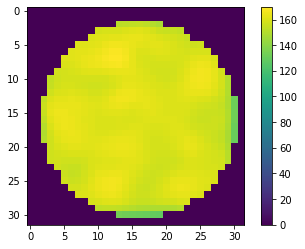

In [268]:
plt.imshow(img*mask); plt.colorbar()

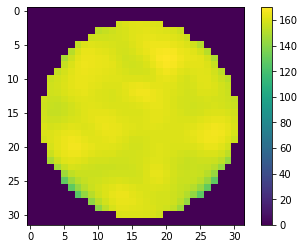

In [270]:
theta = jnp.pi/4
proj, img_rot, pts_rot = rotate_and_project(amp, theta, pts, x_grid, sigma)
plt.imshow(mask*img_rot); plt.colorbar()

In [392]:
N = 1000
sig_noise = 10000

thetas = 2 * jnp.pi * jnp.array(np.random.rand(N)) 

data = fwd_model_vmap(amp, thetas) 
data_noisy = data + np.random.randn(N, nx) * sig_noise
#TODO: add noise

SNR = jnp.sum(data**2)/jnp.sum(data_noisy**2)
print(SNR)

0.16916986


In [ ]:
jnp.max(data)

DeviceArray(5190.147, dtype=float32)

In [433]:
fwd_model, fwd_model_vmap = get_fwd_model(pts, x_grid, sigma)
loss_func, grad_loss_func = get_loss_function(fwd_model_vmap, thetas, data)

In [434]:
N_iters = 200
alpha = 1e-4

x0 = jnp.zeros(amp.shape)

for i in range(N_iters):
    if jnp.mod(i, 10) == 0:
        err = jnp.abs(amp-x0).reshape([nx,nx]) * mask

        print(jnp.sqrt(jnp.sum(err**2)))
        
    x0 = x0 - alpha * grad_loss_func(x0)

258.17288
203.83888
160.65953
126.4526
99.4868
78.395836
62.10833
49.786236
40.76288
34.473896
30.389496
27.979956
26.739166
26.239716
26.167189
26.315804
26.562489
26.838955
27.110184
27.360233


27.58354


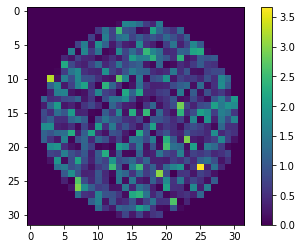

In [435]:
err = jnp.abs(amp-x0).reshape([nx,nx]) * mask
plt.imshow(err); plt.colorbar()
print(jnp.sqrt(jnp.sum(err**2)))

In [436]:
img_rec = pts2img(x0, pts, x_grid, sigma)

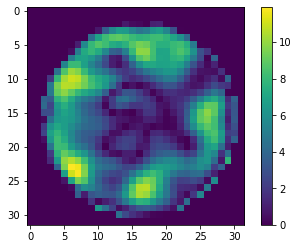

In [437]:
plt.imshow(jnp.abs(img_rec-img)*mask); plt.colorbar()

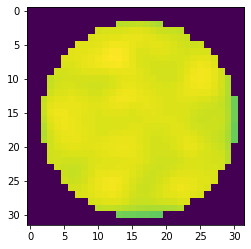

In [438]:
plt.imshow(img*mask)

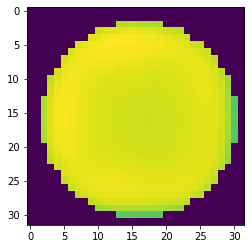

In [439]:
plt.imshow(img_rec*mask)

### Fourier - in progress. should use my own code to do 2d bilinear interpolation

In [523]:
img_f = jnp.fft.fft2(jnp.fft.ifftshift(img))
img_f = img_f.at[0,0].set(0)

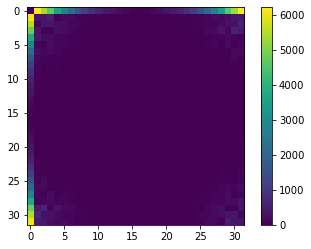

In [525]:
plt.imshow(jnp.abs(img_f)); plt.colorbar()

In [570]:
jax.scipy.ndimage.map_coordinates([[10,20,30],[11,21,31]],[0.5,0], order=1, mode='wrap')

DeviceArray(11, dtype=int32)

In [579]:
from scipy import ndimage
a = [[10,20,30],[11,21,31]]
print(a)
ndimage.map_coordinates(a, [[0.4], [-1]], mode='wrap')

[[10, 20, 30], [11, 21, 31]]


array([20])

In [ ]:
#

def rotate_and_project_f(vol_f, theta, pts):
    """pts are the Fourier grid points, vol_f is the volume in Fourier, flattened"""
    
    R = jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])
    pts = (R @ pts.transpose()).transpose()
    
    
    img = pts2img(amp, pts, x_grid, sig)
    proj = jnp.sum(img, axis=0)
    
    return proj, img, pts